In [245]:
%matplotlib inline
import json
import csv
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import networkx as nx
import seaborn as sns
import pandas as pd
chinese_numbers = u'一二三四五六'
sns.set_context("talk")
pal =  sns.palettes.color_palette()

In [248]:
data_file_path = '../data/cafeDailyRec.json'
data_file = open(data_file_path, 'r')
data = json.load(data_file)
data_file.close()
# with open('../data/daily_sale.json','r') as mjson:
#     m = json.load(mjson)

In [176]:
with open('../data/daily_sale.json','w') as mjson:
    json.dump(m.tolist(), mjson, indent=2)

In [249]:
merchant_file = open('../data/merchant.txt','r')
reader = csv.DictReader(merchant_file, delimiter='\t')
merchants = {}
for row in reader:
    merchants[row['toaccount']] = row
merchant_file.close()

In [152]:
with open('../data/merchant.json','w') as mjson:
    json.dump(merchants, mjson)

In [74]:
with open('../data/loccoordinate_new.json','r') as mjson:
    building_pos = json.load(mjson)
hall_pos = {}
for name in building_pos:
    if name.find(u'食堂')>-1:
        t = 1
        for c in chinese_numbers:
            if name.find(c)>-1:
                break
            t += 1
        hall_pos[t] = building_pos[name]
for i in hall_pos:
    building_pos[i] = hall_pos[i]


In [344]:
img = mpimg.imread('../chart/map2.png')
# with open('../data/time_area_heat_noncafe_data.json','r') as mjson:
#     pos = json.load(mjson)
# with open('../data/time_cafe_heat_data.json','r') as mjson:
#     hall_data = json.load(mjson)
# for hall in hall_data:
#     for u in hall_data[hall]:
#         if pos.get(u) and len(pos[u])<3:
#             pos[u].append(int(hall))
data_set_name = 'time_area_heat_withdomitory_workday_lanchs'
with open('../data/{}.json'.format(data_set_name),'r') as mjson:
    pos_before, pos_after = json.load(mjson)
proper_pos = []
before = True
for pos in (pos_before, pos_after):
    proper_pos += [ building_pos.get(d[0])+[int(d[1]),d[0], before] for d in pos.values() if building_pos.get(d[0])]
    before = False
pos_data = pd.DataFrame(proper_pos, columns=['X','Y','Hall','Building','Before'])

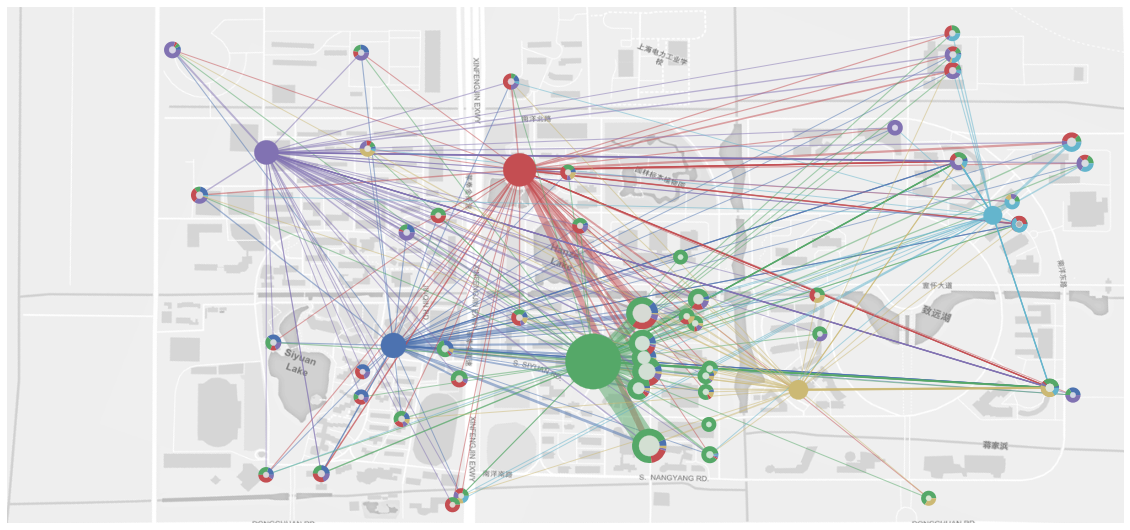

In [404]:
def transition_matrix(G):
    l = G.number_of_nodes()
    tm = np.zeros((l,l))
    all_nodes = sorted(G.nodes())
    for i,n in enumerate(all_nodes):
        nodes = G.successors(n)
        s = float(G.out_degree(n, weight='weight'))
        for sn in nodes:
            tm[i, all_nodes.index(sn)] = G[n][sn]['weight'] / s
    return tm

def plot_map(ax=None):
    upper_right_x = 2754
    upper_right_y = 1273
    if not ax:
        f, ax = plt.subplots(figsize=(20,10))
        ax.set_xlim(0,upper_right_x)
        ax.set_ylim(0,upper_right_y)
        ax.spines["top"].set_visible(False)  
        ax.spines["bottom"].set_visible(False)  
        ax.spines["right"].set_visible(False)  
        ax.spines["left"].set_visible(False)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    ax.imshow(img, extent=(0,upper_right_x,0,upper_right_y))
    return ax

def build_network(data):
    G = nx.DiGraph()
#     buidings = data.Building.unique()
    for i in range(6):
        # from building to hall
        c = data[(data.Hall==i+1) & data.Before].groupby('Building').size()
        nodes = c.keys()
        for node in nodes:
            G.add_edge(node, i+1, weight=c[node])
        # from hall to building
        c = data[(data.Hall==i+1) & ~data.Before].groupby('Building').size()
        nodes = c.keys()
        for node in nodes:
            G.add_edge(i+1, node, weight=c[node])
    return G

def draw_network(G, ax=None):
    node_color = {}
    node_size = {}
    
    for node in G.nodes():
        if node not in range(1,7):
            node_color[node] = (0.8, 0.8, 0.8)
            node_size[node] = nx.degree(G, node, weight='weight') *5+50
    
    for i in range(6):
        node_color[i+1] = pal[i]
        node_size[i+1] = 100
    
    node_color = [node_color[n] for n in G.nodes()]
    node_size = [node_size[n] for n in G.nodes()]
    nx.draw(G.to_undirected(), ax=ax, pos=building_pos, node_color=node_color, node_size=node_size, alpha=0.5)
    return ax

def scatter_pies(ax, xx, pos, s=None, color=None, alpha=1, zorder=1):
    n,_ = xx.shape
    for i in range(n):
        x, p, size = xx[i,:], pos[i], s[i]
        wedges = pie(ax, x, pos=p, colors=color, radius=size, wedgeprops={'linewidth':0, 'alpha':alpha})
        for w in wedges:
            w.set_zorder(zorder)
    return

def customed_draw_network(DG, tm, ax=None, style='normal'):
    # style in ['pie','normal','avg_color']
    from matplotlib.collections import LineCollection
    default_color = (0.4, 0.5, 0.5)
    G = DG.to_undirected()
    # nodes
    node_color = {}
    node_size = {}
    nodes = sorted(G.nodes())
    l = len(nodes)
    for i, node in enumerate(nodes):
        # default color
        node_color[node] = default_color
        
        # assign average color of node's successors'
        if style!='normal' and node not in range(1,7):
            c = np.zeros(3)
            for j in range(6):
                c += tm[i,j]*np.asarray(pal[j])
            node_color[node] = c
        node_size[node] = nx.degree(G, node, weight='weight')
    for i in range(6):
        node_color[i+1] = pal[i]
#         node_size[i+1] = 100
    node_color = [node_color[n] for n in nodes]
    
    node_size = np.asarray([node_size[n] for n in nodes])
    min_size = min(node_size)
    factor = 3000.0 / (max(node_size)-min_size)
    node_size = (node_size-min_size)*factor+70
    node_pos = np.asarray([building_pos[n] for n in nodes])
    node_collection = ax.scatter(node_pos[:6,0], node_pos[:6,1], s=node_size[:6], alpha=1, color=node_color[:6])
    node_collection.set_zorder(2)
    factor = 1.0
    if style=='pie':
        scatter_pies(ax, tm[6:,:], node_pos[6:,:], s=np.sqrt(node_size[6:])+10, color=pal, alpha=1, zorder=2)
        node_collection = ax.scatter(node_pos[6:,0], node_pos[6:,1], s=node_size[6:]*0.4, alpha=1,\
                                     color=np.asarray(node_color[6:])*0.3+np.ones_like(node_color[6:])*0.7)
    else:
        node_collection = ax.scatter(node_pos[6:,0], node_pos[6:,1], s=node_size[6:], alpha=1, color=node_color[6:])
    node_collection.set_zorder(2.5)

    # edges
    edges = G.edges()
    edge_pos = [(building_pos[e[0]], building_pos[e[1]]) for e in edges]
    edge_color = []
    for e in edges:
        c = default_color
        if e[0] in range(1,7):
            c = pal[e[0]-1]
        elif e[1] in range(1,7):
            c = pal[e[1]-1]
        edge_color.append(c)
    
    edge_width = np.asarray([G[e[0]][e[1]]['weight'] for e in edges])
    max_ew = max(edge_width)
    min_ew = min(edge_width)
    edge_width = 20./(max_ew-min_ew)*(edge_width-min_ew)+1
    edge_collection = LineCollection(edge_pos,
                                     colors=edge_color,
                                     linewidths=edge_width,
                                     alpha=0.5,
#                                      antialiaseds=(1,),
#                                      linestyle=style,
#                                      transOffset = ax.transData,
                                     )

    edge_collection.set_zorder(1)  # edges go behind nodes
#     edge_collection.set_label(label)
    ax.add_collection(edge_collection)
    return ax
    
def plot_heat_map(data ,ax=None, color=None):
    ax = plot_map(ax)
    grouped = data.groupby('Building')
    
#     for b in b_count.keys():
#         c = plt.Circle()
#         ax.plot
#     ax.hexbin(data.X, data.Y)
    
    ax.scatter(grouped.first().X, grouped.first().Y, s=grouped.size()*5+50, alpha=0.8, color=color)
    return ax
ax = plot_map()
# G = build_network(pos_data)
# tm = transition_matrix(G)
customed_draw_network(G, tm, ax=ax, style='pie')
# ax.figure.savefig('../chart/{}.png'.format(data_set_name),dpi=90)
# for i in range(6):
#     ax = plot_heat_map(pos_data[pos_data.Hall==i+1], color=pal[i], ax=ax)

y


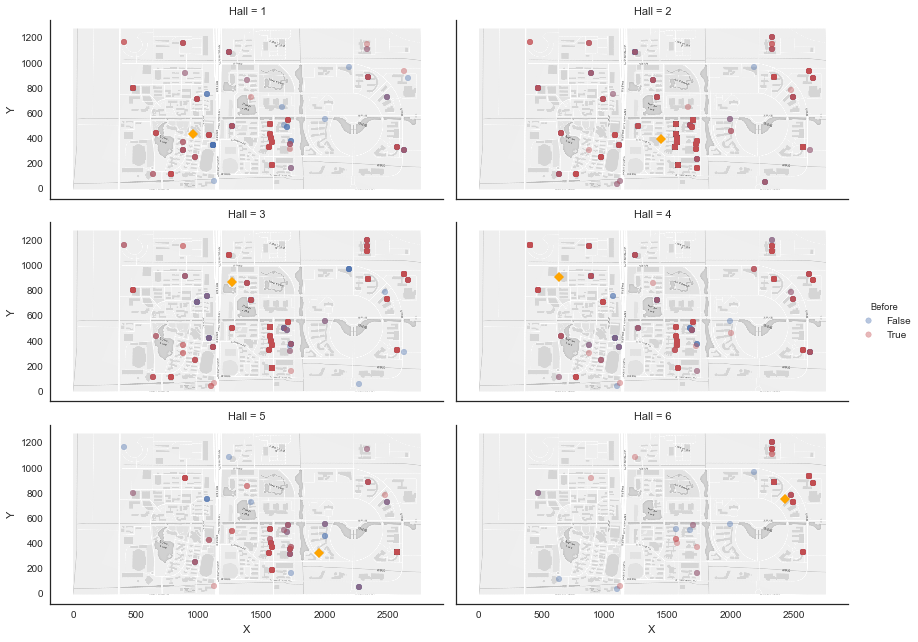

In [406]:
upper_right_x = 2754
upper_right_y = 1273
# plt.scatter(px, py)
# sns.kdeplot(np.asarray(pos.values()),norm=LogNorm(), shade=True, alpha=0.5 );
# sns.jointplot(px, py, kind="hex")
# plt.hist2d(x,y,bins=(30,15), norm=LogNorm(), cmap=plt.cm.Blues, alpha=0.7 )
sns.set(style="white")
pal =  sns.palettes.color_palette()
g = sns.FacetGrid(pos_data, hue='Before', col='Hall', col_wrap=2, xlim=(0, upper_right_x), ylim=(0, upper_right_y), size=3, aspect=2, palette=[pal[0],pal[2]])
# g.set(xlim=(0, upper_right_x), ylim=(0, upper_right_y))
# g.fig.set_figheight(60)
# g.fig.set_figwidth(20)
for i in range(len(g.axes)):
    ax = g.axes.flat[i]
    ax.imshow(img, extent=(0,upper_right_x,0,upper_right_y))
    ax.plot(hall_pos[i+1][0], hall_pos[i+1][1], 'D', color='orange')
g.map(plt.scatter,'X','Y', s=30, alpha=.4, linewidth=0.5)
# g.map(plt.hist2d,'X','Y', bins=(30,15))
g.add_legend();
print 'y'


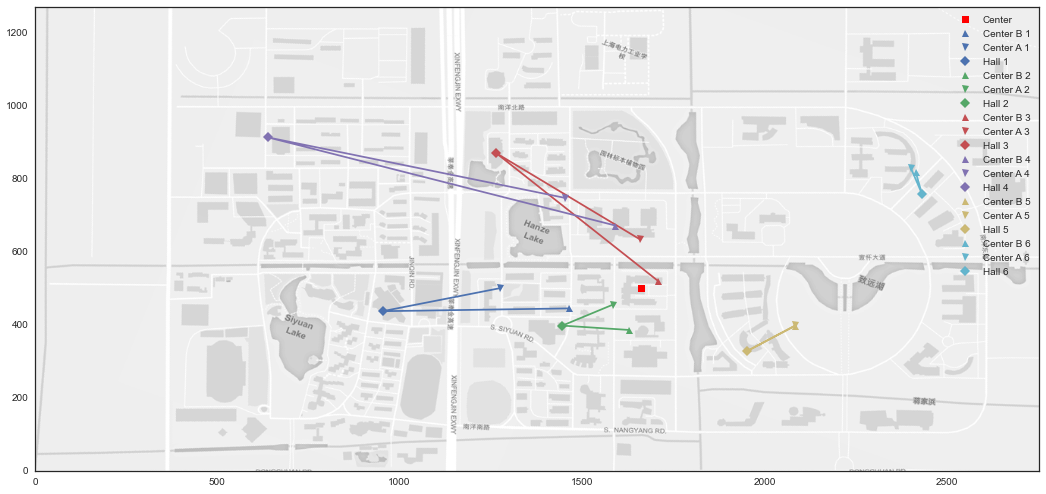

In [405]:
import math
plt.figure(figsize=(18,9))
plt.xlim(0,upper_right_x)
plt.ylim(0,upper_right_y)
plt.imshow(img, extent=(0,upper_right_x,0,upper_right_y))
dist = [0]*6
cp = pos_data.mean()[:2]
plt.plot(cp[0],cp[1],'rs', label='Center')
for i in range(6):
    tmp = pos_data[(pos_data.Hall==i+1) & pos_data.Before].mean()
    plt.plot(tmp.X, tmp.Y, '^', color=pal[i], label='Center B {}'.format(i+1))
    tmp2 = pos_data[(pos_data.Hall==i+1) & ~pos_data.Before].mean()
    plt.plot(tmp2.X, tmp2.Y, 'v', color=pal[i], label='Center A {}'.format(i+1))
    plt.plot(hall_pos[i+1][0], hall_pos[i+1][1], 'D', color=pal[i], label='Hall {}'.format(i+1))
    plt.plot([ tmp.X, hall_pos[i+1][0], tmp2.X], [ tmp.Y, hall_pos[i+1][1], tmp2.Y], '-', color=pal[i])
#     dist[i] = math.sqrt((tmp.X-hall_pos[i+1][0])**2+(tmp.Y-hall_pos[i+1][1])**2)
plt.legend()

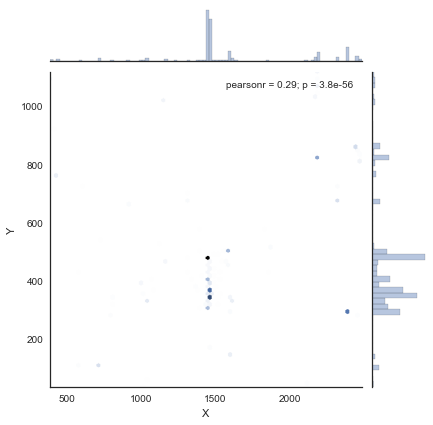

In [161]:
sns.jointplot(pos_data.X, pos_data.Y, kind="hex")

In [251]:
day_n = 153
merchant_list = data.keys()
day_list = range(1,day_n+1)
m = np.empty((len(merchant_list),day_n+1))
m[:] = 0
for mi,merchant in enumerate(merchant_list):
    for day in data[merchant]:
        total = 0
        for u in data[merchant][day]:
            total += data[merchant][day][u]['times']
        m[mi,int(day)] = total
        
for key in merchants:
    merchant = merchants[key]
    name = merchant['codename'].decode('utf-8')
    if name.find(u'食堂')>-1:
        t = 1
        for c in chinese_numbers:
            if name.find(c)>-1:
                break
            t += 1
        merchant['building'] = t

for key in merchant_list:
    merchant = merchants[key]
    print merchant['toaccount'],merchant['codename'],merchant.get('building')
        

1000178 闵行第六食堂 6
1000241 闵行第一食堂2 1
1000242 闵行第一食堂2 1
1000222 闵行第二食堂 2
1000125 闵行第一食堂 1
1000220 闵行第四食堂 4
1000221 闵行第一食堂 1
1000003 闵行第一食堂 1
1000204 闵行第一食堂 1
1000040 闵行第二食堂 2
1000041 闵行第二食堂 2
1000047 闵行第三食堂 3
1000187 闵行第四食堂 4
1000186 闵行第四食堂 4
1000185 闵行第四食堂 4
1000001 闵行第一食堂 1
1000183 闵行第四食堂 4
1000182 闵行第四食堂 4
1000181 闵行第四食堂 4
1000180 闵行第六食堂 6
1000031 闵行第二食堂 2
1000105 闵行第五食堂 5
1000027 闵行第二食堂 2
1000103 闵行第五食堂 5
1000246 新闵行第四食堂 4
1000143 教育超市柜台 None
1000007 闵行第一食堂 1
1000062 闵行第五食堂 5
1000005 闵行第一食堂 1
1000002 闵行第一食堂2 1
1000029 闵行第二食堂 2
1000108 闵行第四食堂 4
1000184 闵行第四食堂 4
1000038 闵行第二食堂 2
1000202 闵行第一食堂 1
1000060 闵行第四食堂 4
1000019 闵行西区超市 None
1000011 闵行第一食堂 1
1000010 闵行第一食堂 1
1000055 闵行第四食堂 4
1000098 图书馆 None
1000057 闵行第四食堂 4
1000056 闵行第四食堂 4
1000176 闵行第一食堂2 1
1000219 闵行第一食堂2 1
1000175 闵行西区超市 None
1000231 闵行第三食堂 3
1000216 闵行第四食堂 4
1000215 闵行第二食堂 2
1000179 闵行第六食堂 6
1000213 闵行第四食堂 4
1000212 闵行第四食堂 4
1000237 曦潮书店 None
1000210 闵行第四食堂 4
1000037 闵行第二食堂 2
1000159 闵行第四食堂 4
1000233 闵行第三食堂 3
1000015 闵行第一食堂2

In [252]:
sales = np.zeros((6, day_n+1))
for mi,key in enumerate(merchant_list):
    b = merchants[key].get('building')
    if b:
        sales[b-1,:] += m[mi,:]

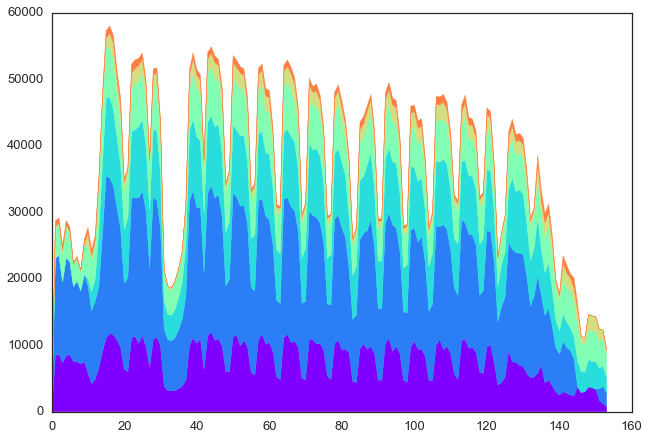

In [253]:
def plot_filled_stacks(x, ratio=False):
    n,l = x.shape
    if ratio:
        tsum = x.sum(axis=0)
        tx  = np.empty_like(x)
        for i in range(n):
            tx[i,:] = x[i,:] / tsum
        x = tx
        plt.ylim((0,1))
    colors = [plt.cm.rainbow(float(i)/n) for i in range(n)]
    sm = np.zeros((n+1,l))
#     sm[0,:] = x[0,:]
#     plt.plot(sm[0,:])
#     plt.fill_between(range(l),0,sm[0,:])
    for i in range(1,n+1):
        sm[i,:] = sm[i-1,:] + x[i-1,:]
    for i in range(1,n+1):
#         plt.plot(sm[i,:], color=colors[i])
        plt.fill_between(range(l),sm[i-1,:],sm[i,:],color=colors[i-1], facecolor=colors[i-1])
    plt.show()

plot_filled_stacks(sales)

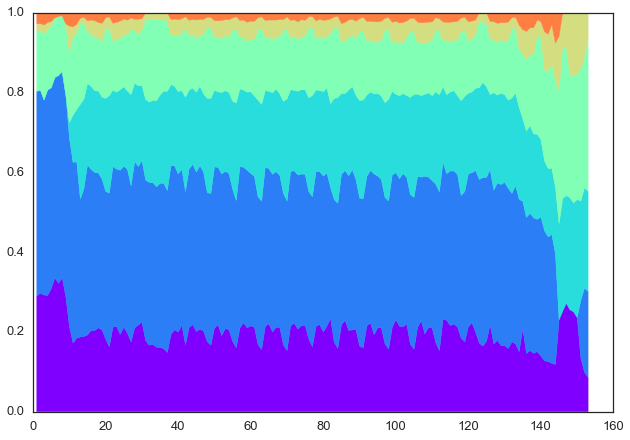

In [254]:
plot_filled_stacks(sales, ratio=True)

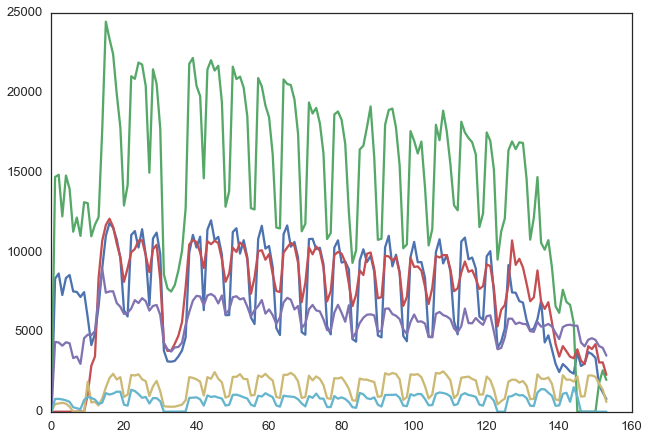

In [256]:
for i in range(6):
    plt.plot(sales[i,:])

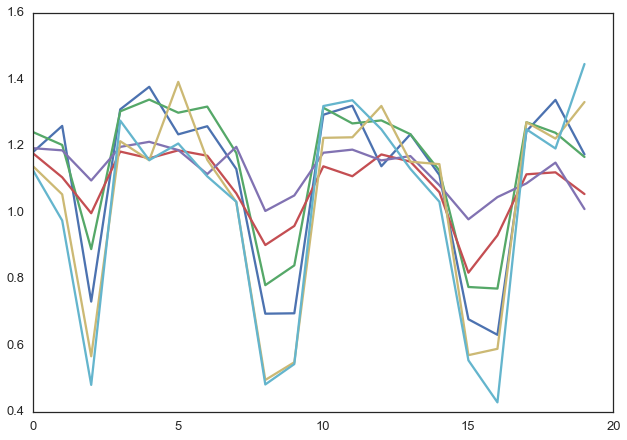

In [257]:
long_avg_sales = sales[:,40:120].mean(axis=1)
for i in range(6):
    plt.plot(sales[i,40:60]/long_avg_sales[i])

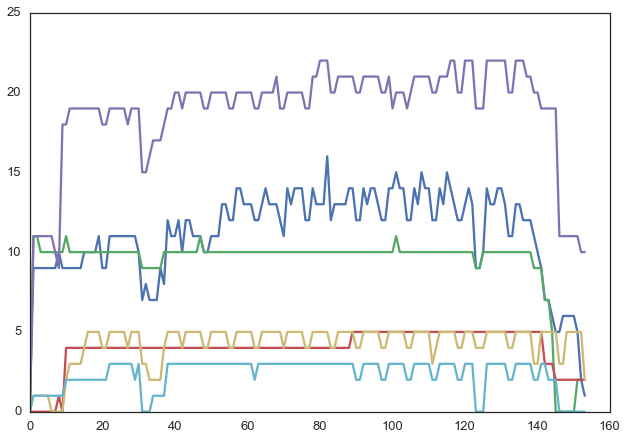

In [259]:
om = np.empty((len(merchant_list),day_n+1))
om[:] = False
for mi,key in enumerate(merchant_list):
    for day in data[key]:
        om[mi, int(day)] = len(data[key][day])>0
oh = np.zeros((6, day_n+1))
for mi,key in enumerate(merchant_list):
    b = merchants[key].get('building')
    if b:
        oh[b-1,:] += om[mi,:]
for i in range(6):
    plt.plot(oh[i,:])
plt.show()

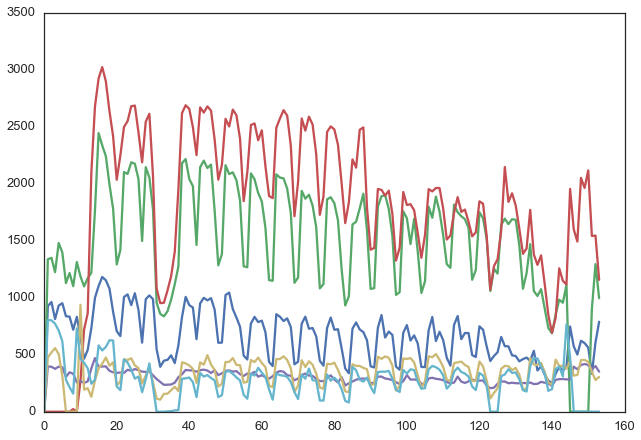

In [260]:
for i in range(6):
    tmp = sales[i,:].copy()
    for j in range(day_n+1):
        if oh[i,j]==0:
            tmp[j] = 0
        else:
            tmp[j] = sales[i,j]/ oh[i,j]
    plt.plot(tmp)
plt.show()

In [261]:
avg_sale = np.zeros(len(merchant_list))
for mi,key in enumerate(merchant_list):
    open_days = sum(om[mi,:])
    if open_days>0:
        avg_sale[mi] = sum(m[mi,:])/open_days


In [262]:
for mi,key in enumerate(merchant_list):
    print merchants[key]['codename'],merchants[key]['accountname'], int(avg_sale[mi])

闵行第六食堂 六餐东一楼餐厅 637
闵行第一食堂2 达通一餐蔬菜店 8
闵行第一食堂2 达通一餐水果店 145
闵行第二食堂 上海快餐定额卡 7
闵行第一食堂 供应点1 35
闵行第四食堂 后发定额卡（第四餐饮） 15
闵行第一食堂 一餐教工定额卡 1
闵行第一食堂 中式点心 1514
闵行第一食堂 松叶蔬菜 16
闵行第二食堂 二大楼教工餐厅 845
闵行第二食堂 绿园餐厅 2078
闵行第三食堂 北区教育超市 1526
闵行第四食堂 点心 333
闵行第四食堂 甜点 62
闵行第四食堂 烧腊饭 175
闵行第一食堂 淮扬快餐 1654
闵行第四食堂 笼仔饭 72
闵行第四食堂 麻辣烫 207
闵行第四食堂 串串烧 142
闵行第六食堂 六餐伊诺咖啡 7
闵行第二食堂 川味点心 2618
闵行第五食堂 第五餐饮教育超市 184
闵行第二食堂 上海快餐 2721
闵行第五食堂 二楼面馆 394
新闵行第四食堂 闵行四餐面包房 48
教育超市柜台 教育超市 391
闵行第一食堂 梦园面包房2 446
闵行第五食堂 二楼快餐厅 773
闵行第一食堂 一餐教工餐厅 461
闵行第一食堂2 海派食府 455
闵行第二食堂 西北面点 1608
闵行第四食堂 苏记麻辣烫 77
闵行第四食堂 粉面饭 104
闵行第二食堂 大众餐厅 1425
闵行第一食堂 闵行一餐临时 74
闵行第四食堂 炖品 417
闵行西区超市 哈乐之家 1447
闵行第一食堂 顺日北小吃 1371
闵行第一食堂 吉祥小厨 985
闵行第四食堂 东餐厅 1012
图书馆 借还书 19
闵行第四食堂 面点 1242
闵行第四食堂 西餐厅 105
闵行第一食堂2 甜魔咖啡 204
闵行第一食堂2 一餐清真 318
闵行西区超市 浓清水果店（哈乐餐厅） 83
闵行第三食堂 闵行第三餐饮外婆桥 1989
闵行第四食堂 风味煲仔饭 227
闵行第二食堂 西式快餐 578
闵行第六食堂 六餐面馆 216
闵行第四食堂 粥档 414
闵行第四食堂 烤肉 283
曦潮书店 曦潮书店 1
闵行第四食堂 炒面 119
闵行第二食堂 教育超市 1429
闵行第四食堂 教工餐厅 803
闵行第三食堂 闵行第三餐饮学生餐厅 4347
闵行第一食堂2 川菜 503
闵行第一食堂2 高知餐厅 75
闵行第四食堂 土豆粉 141
闵行超市

1 18


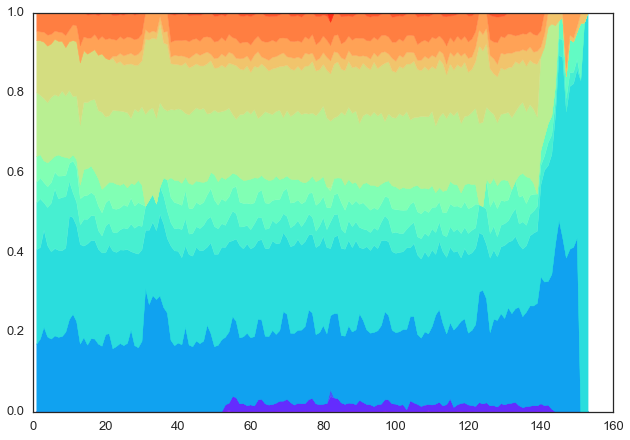

2 11


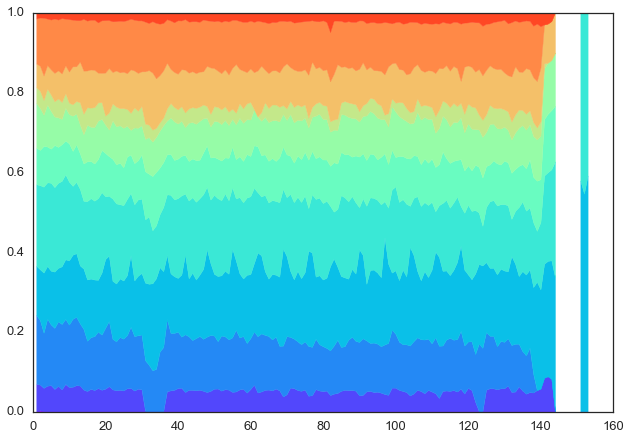

3 5


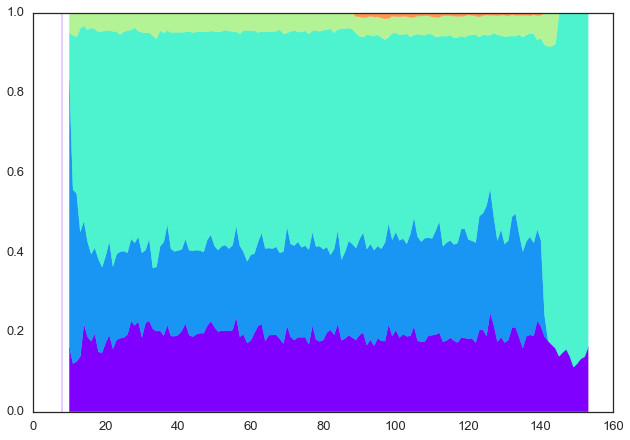

4 23


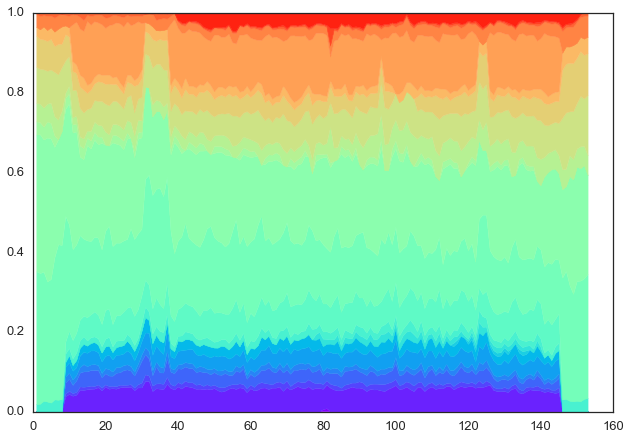

5 5


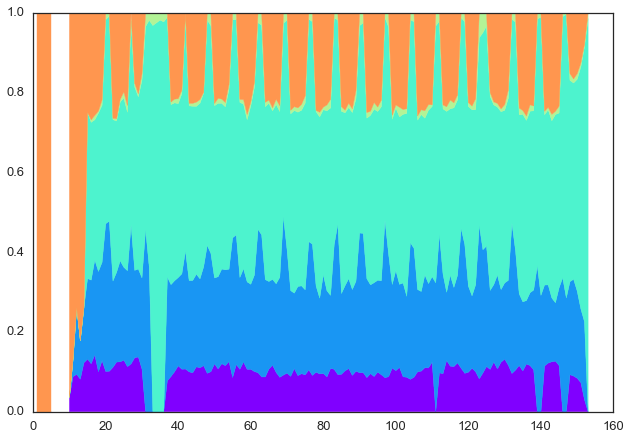

6 3


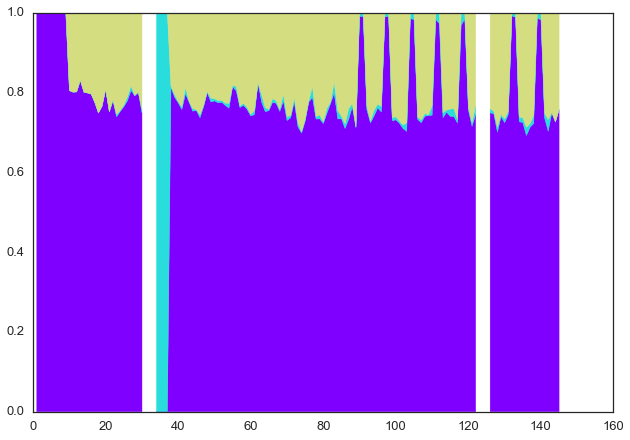

In [263]:
for b in range(1,7):
    tmp = []
    for mi,key in enumerate(merchant_list):
        if merchants[key].get('building')==b:
            tmp.append(m[mi,:])
    plt.figure()
    print b, len(tmp)
    plot_filled_stacks(np.array(tmp), ratio=True)

In [264]:
merchant_week_sale = np.zeros((len(merchant_list), 7))
for mi,key in enumerate(merchant_list):
    for d in range(40,110):
        merchant_week_sale[mi, d % 7] += m[mi, d]
        
hall_week_sale = np.zeros((6, 7))
for mi,key in enumerate(merchant_list):
    b = merchants[key].get('building')
    if b:
        hall_week_sale[b-1,:] += merchant_week_sale[mi,:]

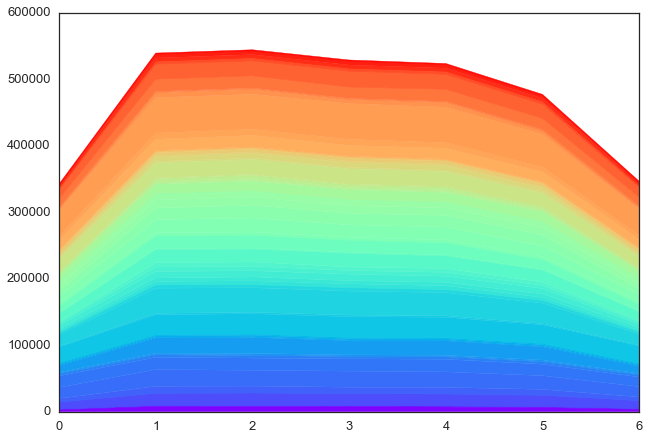

In [265]:
plot_filled_stacks(merchant_week_sale)

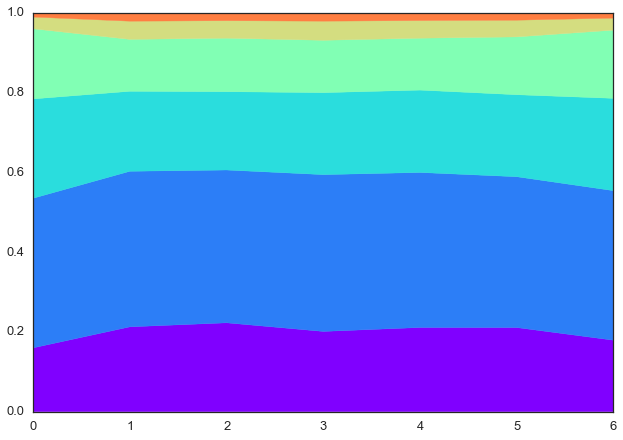

In [266]:
plot_filled_stacks(hall_week_sale,ratio=True)

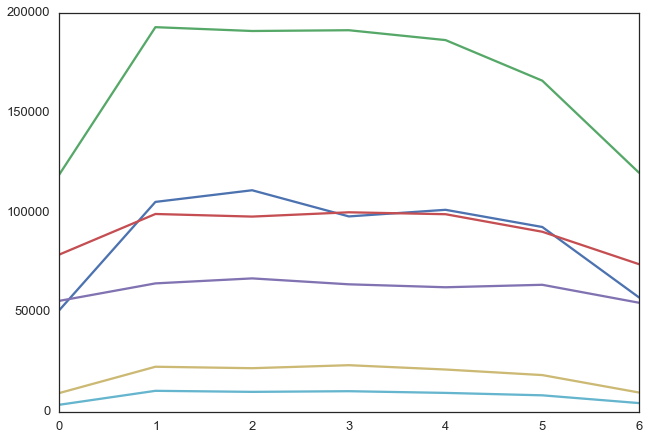

In [267]:
for i in range(6):
    plt.plot(hall_week_sale[i,:])

一 1.26207943868 0.574784593021 2.19574333412
二 1.15794839405 0.711514367214 1.6274420411
三 1.09559098688 0.810491819706 1.35176069671
四 1.08497377839 0.886874815892 1.22336744595
五 1.29462401422 0.514772853493 2.51494228072
六 1.30670994899 0.428120429494 3.05220180811


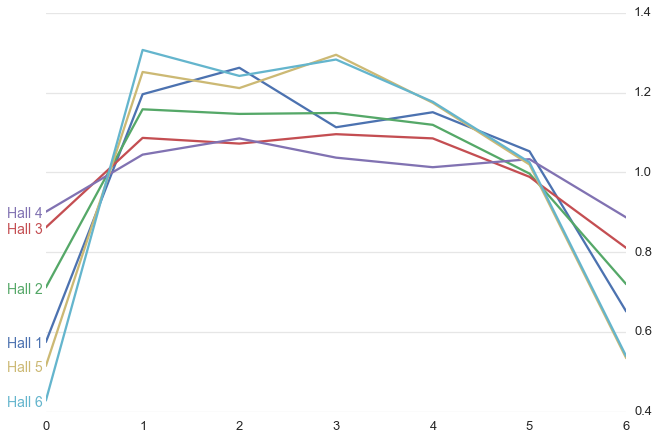

In [323]:
sns.set_style('white')
f, ax = plt.subplots()
ax.spines["top"].set_visible(False)  
ax.spines["bottom"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.spines["left"].set_visible(False)
ax.yaxis.tick_right()
ax.yaxis.grid(color=(0.9,0.9,0.9))
# sns.despine(left=True, right=True)
for i in range(6):
    tmp = hall_week_sale[i,:]/hall_week_sale[i,:].mean()
    plt.plot(tmp)
    print chinese_numbers[i], max(tmp), min(tmp), max(tmp)/min(tmp)
    plt.text(-0.4, tmp[0]-0.015, u'Hall {}'.format(i+1), fontsize=14, color=pal[i])

In [4]:
%qtconsole

In [198]:
def pie(ax, x, pos=None ,explode=None, labels=None, colors=None,
            autopct=None, pctdistance=0.6, shadow=False, labeldistance=1.1,
            startangle=None, radius=None, counterclock=True,
            wedgeprops=None, textprops=None):
        import matplotlib.patches as mpatches
        import math
        self = ax
        x = np.asarray(x).astype(np.float32)

        sx = float(x.sum())
        if sx > 1:
            x = np.divide(x, sx)

        if labels is None:
            labels = [''] * len(x)
        if explode is None:
            explode = [0] * len(x)
        assert(len(x) == len(labels))
        assert(len(x) == len(explode))
        if colors is None:
            colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k', 'w')

        center = 0, 0
        if pos is not None:
          center = pos
        if radius is None:
            radius = 1

        # Starting theta1 is the start fraction of the circle
        if startangle is None:
            theta1 = 0
        else:
            theta1 = startangle / 360.0

        # set default values in wedge_prop
        if wedgeprops is None:
            wedgeprops = {}
        if 'clip_on' not in wedgeprops:
            wedgeprops['clip_on'] = False

        if textprops is None:
            textprops = {}
        if 'clip_on' not in textprops:
            textprops['clip_on'] = False

        texts = []
        slices = []
        autotexts = []

        i = 0
        for frac, label, expl in zip(x, labels, explode):
            x, y = center
            theta2 = (theta1 + frac) if counterclock else (theta1 - frac)
            thetam = 2 * math.pi * 0.5 * (theta1 + theta2)
            x += expl * math.cos(thetam)
            y += expl * math.sin(thetam)

            w = mpatches.Wedge((x, y), radius, 360. * min(theta1, theta2),
                            360. * max(theta1, theta2),
                            facecolor=colors[i % len(colors)],
                            **wedgeprops)
            slices.append(w)
            self.add_patch(w)
            w.set_label(label)

            if shadow:
                # make sure to add a shadow after the call to
                # add_patch so the figure and transform props will be
                # set
                shad = mpatches.Shadow(w, -0.02, -0.02)
                shad.set_zorder(0.9 * w.get_zorder())
                shad.set_label('_nolegend_')
                self.add_patch(shad)

            xt = x + labeldistance * radius * math.cos(thetam)
            yt = y + labeldistance * radius * math.sin(thetam)


            theta1 = theta2
            i += 1
        return slices